# Connect Forest Management Model with Forest Carbon Budget Model (without calibration)

## Set up Modelling Environment

In [40]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
from util_opt import compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_maxstock, cbm_report, plugin_c_curves, compare_ws3_cbm, compile_events
import pickle

In [41]:
#Start Calculating the Running Time
Start = time.time()

In [42]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
case_study = 'equitysilver'

## Create and Run `ForestModel` instance

In [43]:
fm = ws3.forest.ForestModel(model_name='equitysilver',
                            model_path='./data/woodstock_model_files_equitysilver',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

fm.grow()

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

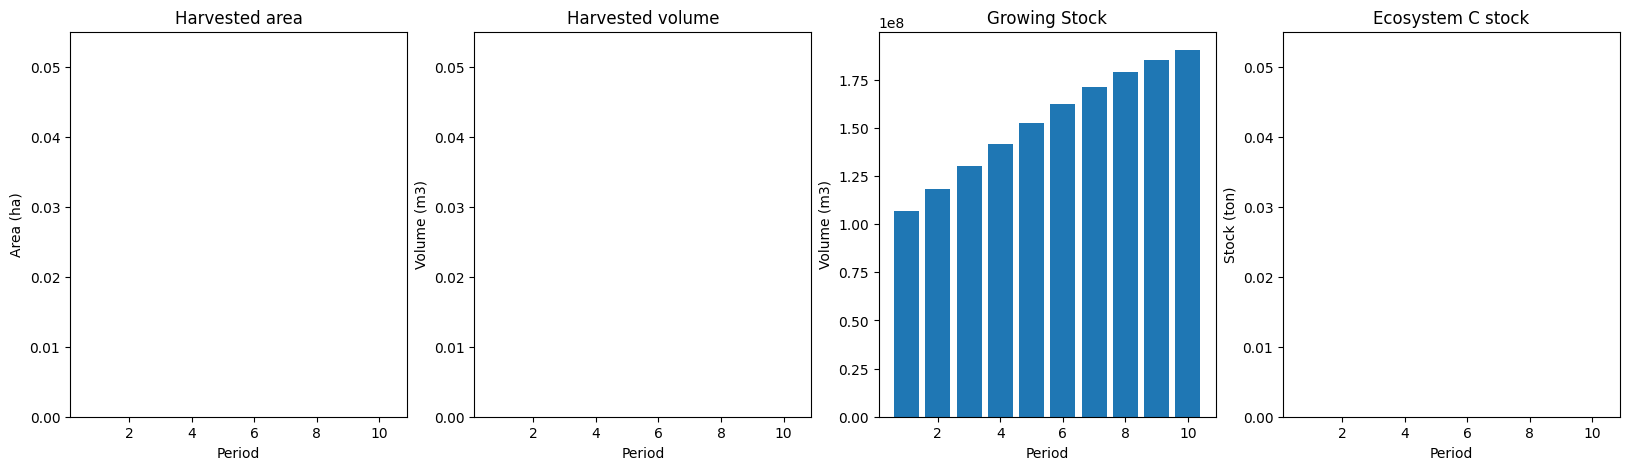

In [44]:
# Check the Forest Inventory of the Forest Model
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

## Hard-link `ForestModel` to `libcbm`

Prepare CBM input files

In [45]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[5] == dtype_key[4] else 'harvest'

Here are other two ways to generate sit tables. But they are only suitbale for small forest model since they take too much running time and memory

In [46]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                        disturbance_type_mapping=disturbance_type_mapping)

In [47]:
from libcbm.input.sit import sit_reader
from libcbm.input.sit import sit_cbm_factory 
from libcbm.model.cbm.cbm_output import CBMOutput
from libcbm.storage.backends import BackendType
from libcbm.model.cbm import cbm_simulator
sit_data = sit_reader.parse(sit_classifiers=sit_tables['sit_classifiers'],
                            sit_disturbance_types=sit_tables['sit_disturbance_types'],
                            sit_age_classes=sit_tables['sit_age_classes'],
                            sit_inventory=sit_tables['sit_inventory'],
                            sit_yield=sit_tables['sit_yield'],
                            sit_events=sit_tables['sit_events'],
                            sit_transitions=sit_tables['sit_transitions'],
                            sit_eligibilities=None)
sit = sit_cbm_factory.initialize_sit(sit_data=sit_data, config=sit_config)
classifiers, inventory = sit_cbm_factory.initialize_inventory(sit)
cbm_output = CBMOutput(classifier_map=sit.classifier_value_names,
                       disturbance_type_map=sit.disturbance_name_map)
with sit_cbm_factory.initialize_cbm(sit) as cbm:
    # Create a function to apply rule based disturbance events and transition rules based on the SIT input
    rule_based_processor = sit_cbm_factory.create_sit_rule_based_processor(sit, cbm)
    # The following line of code spins up the CBM inventory and runs it through 200 timesteps.
    cbm_simulator.simulate(cbm,
                           n_steps=n_steps,
                           classifiers=classifiers,
                           inventory=inventory,
                           pre_dynamics_func=rule_based_processor.pre_dynamics_func,
                           reporting_func=cbm_output.append_simulation_result,
                           backend_type=BackendType.numpy)
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                        
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']

In [48]:
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
ecosystem_pools = biomass_pools + dom_pools
# all_pools = biomass_pools + dom_pools + emissions_pools
all_pools = biomass_pools + dom_pools

In [49]:
# Define Time Steps
n_steps = fm.horizon * fm.period_length

# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [50]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]

decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]
grossgrowth_ag = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
]

grossgrowth_bg = [
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

product_flux = [
     "DisturbanceSoftProduction",
     "DisturbanceHardProduction",
     "DisturbanceDOMProduction",
]

GrossGrowth_AG = flux[[
        "DeltaBiomass_AG",
        "TurnoverMerchLitterInput",
        "TurnoverFolLitterInput",
        "TurnoverOthLitterInput",
        ]].sum(axis=1)

GrossGrowth_BG = flux[[
        "DeltaBiomass_BG",
        "TurnoverCoarseLitterInput",
        "TurnoverFineLitterInput",
        ]].sum(axis=1)

In [51]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
pools = ecosystem_pools
fluxes = decay_emissions_fluxes + disturbance_emissions_fluxes
gross_growth = grossgrowth_ag + grossgrowth_bg

sum_pools = ['ecosystem', 'biomass', 'DOM']

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Stock_Change
Year,,,,,,
0,5.822073e+07,1.222542e+08,1.804750e+08,0.000000e+00,0.000000e+00,0.000000
1,5.871998e+07,1.221095e+08,1.808295e+08,2.698916e+06,3.053426e+06,-354510.028018
2,5.921411e+07,1.219807e+08,1.811948e+08,2.699385e+06,3.064685e+06,-365300.196877
3,5.970696e+07,1.218664e+08,1.815734e+08,2.700477e+06,3.079076e+06,-378598.301206
4,6.020047e+07,1.217660e+08,1.819664e+08,2.702128e+06,3.095212e+06,-393083.488615
...,...,...,...,...,...,...
96,8.888489e+07,1.328625e+08,2.217474e+08,3.118794e+06,3.422864e+06,-304069.939522
97,8.900069e+07,1.330478e+08,2.220485e+08,3.121645e+06,3.422719e+06,-301073.773681
98,8.910958e+07,1.332344e+08,2.223440e+08,3.124494e+06,3.420029e+06,-295534.434088


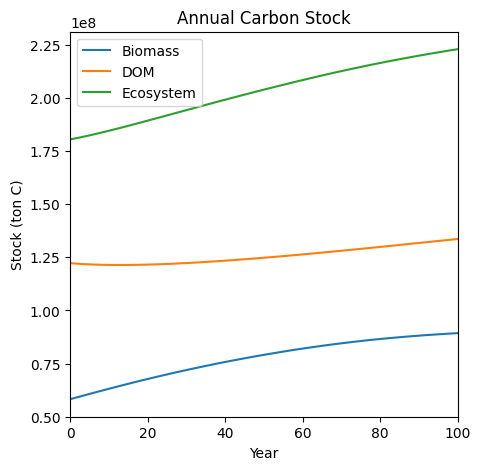

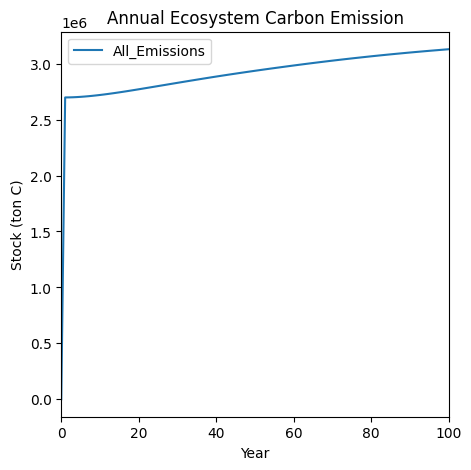

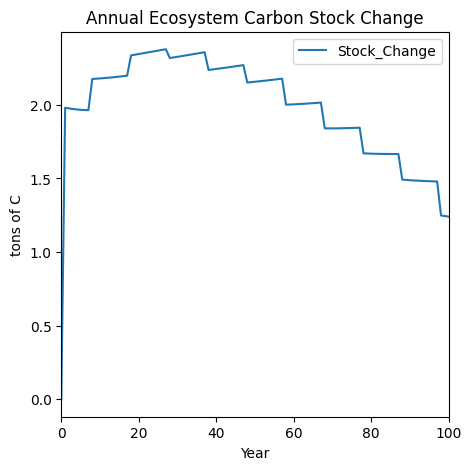

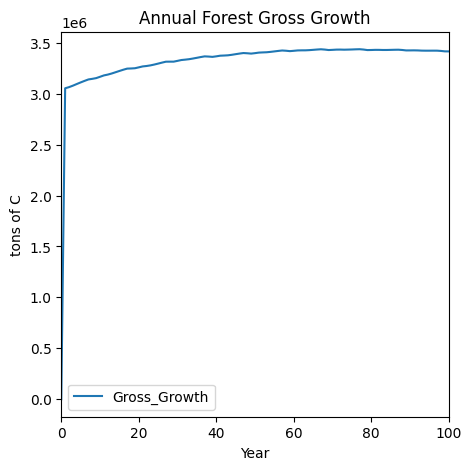

In [52]:
# Report Annual CBM Results
# cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

## Generate and Add Carbon Yield Curves

Carbon in product pools is considered a 100% immediate emission after harvesting activities.

Rebuild the inventory table. Set age to 0 and area to 1.0 ha.

The `sit_events` table should be empty.

In [53]:
sit_tables['sit_events']

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,min_softwood_age,max_softwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year


In [54]:
sit_tables['sit_inventory']

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa03,0,1,100,1,1,softwood,FALSE,8,0.187482,0,0,fire,fire
1,tsa03,0,1,100,1,1,softwood,FALSE,15,0.475883,0,0,fire,fire
2,tsa03,0,1,100,1,1,softwood,FALSE,16,0.267715,0,0,fire,fire
3,tsa03,0,1,100,1,1,softwood,FALSE,27,0.952389,0,0,fire,fire
4,tsa03,0,1,100,1,1,softwood,FALSE,34,2.410174,0,0,fire,fire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17018,tsa24,1,160,1211,160,160,hardwood,FALSE,98,2.858212,0,0,fire,fire
17019,tsa24,1,160,1211,160,160,hardwood,FALSE,143,2.225029,0,0,fire,fire
17020,tsa24,1,160,1211,160,160,hardwood,FALSE,188,1.399030,0,0,fire,fire
17021,tsa24,1,166,104,166,166,softwood,FALSE,213,0.262391,0,0,fire,fire


In [55]:
# Set Age and Area to 1 and 1.0
df = sit_tables['sit_inventory']
df['age'] = df['age'].apply(lambda x: 1)
df['area'] = df['area'].apply(lambda x: 1.0)
df = df.drop_duplicates(ignore_index=True)
df

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa03,0,1,100,1,1,softwood,FALSE,1,1.0,0,0,fire,fire
1,tsa03,0,2,100,2,2,softwood,FALSE,1,1.0,0,0,fire,fire
2,tsa03,0,3,100,3,3,softwood,FALSE,1,1.0,0,0,fire,fire
3,tsa03,0,4,204,4,4,softwood,FALSE,1,1.0,0,0,fire,fire
4,tsa03,0,5,204,5,5,softwood,FALSE,1,1.0,0,0,fire,fire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,tsa24,1,158,1201,158,158,hardwood,FALSE,1,1.0,0,0,fire,fire
447,tsa24,1,159,1201,159,159,hardwood,FALSE,1,1.0,0,0,fire,fire
448,tsa24,1,160,1211,160,160,hardwood,FALSE,1,1.0,0,0,fire,fire
449,tsa24,1,166,104,166,166,softwood,FALSE,1,1.0,0,0,fire,fire


Use the following code if any of the developments have no harvesting circumstances.

In [56]:
# # Replace the Sit Inventory File in the Sit Table
sit_tables['sit_inventory'] = df

In [57]:
# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

In [58]:
# Generate Carbon Pool and Flux Indicators
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
# fi = cbm_output.classifiers.to_pandas().merge(cbm_output.flux.to_pandas(), 
#                                               left_on=["identifier", "timestep"], 
#                                               right_on=["identifier", "timestep"])

In [59]:
# Define Development Type Keys
pi['dtype_key'] = pi.apply(lambda r: '%s %s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4'], r['theme5']), axis=1)
# fi['dtype_key'] = fi.apply(lambda r: '%s %s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4'], r['theme5']), axis=1)

In [60]:
# Generate Carbon Pool anf Flux Curves
c_curves_p = pi.groupby(['dtype_key', 'timestep'], as_index=True)[all_pools].sum()
# c_curves_f = fi.groupby(['dtype_key', 'timestep'], as_index=True)[all_fluxes].sum()

In [61]:
# Generate sum carbon pool curves
c_curves_p['ecosystem'] = c_curves_p[ecosystem_pools].sum(axis=1)
c_curves_p['biomass'] = c_curves_p[biomass_pools].sum(axis=1)
c_curves_p['DOM'] = c_curves_p[dom_pools].sum(axis=1)

In [62]:
# Generate carbon yield curves for net emission
# c_curves_f['total_emissions'] = c_curves_f[fluxes].sum(axis=1)
# c_curves_f['net_fluxes'] = c_curves_f[npp_fluxes+["TurnoverMerchLitterInput","TurnoverFolLitterInput","TurnoverOthLitterInput","TurnoverCoarseLitterInput","TurnoverFineLitterInput"]].sum(axis=1)-c_curves_f[decay_emissions_fluxes].sum(axis=1)

In [63]:
c_curves_p

SoftwoodMerch  SoftwoodFoliage  SoftwoodOther  \
dtype_key         timestep                                                  
tsa03 0 1 100 1 1 0          3.852012e-10         0.000132       0.000000   
                  1          1.583716e-08         0.000966       0.000000   
                  2          1.392515e-07         0.003097       0.000000   
                  3          6.511270e-07         0.007077       0.000000   
                  4          2.154041e-06         0.013433       0.000000   
...                                   ...              ...            ...   
tsa24 1 9 304 9 9 96         2.267848e+01         4.860306      20.649580   
                  97         2.315970e+01         4.893961      20.734717   
                  98         2.363957e+01         4.927416      20.819487   
                  99         2.411813e+01         4.960673      20.903901   
                  100        2.459542e+01         4.993734      20.987966   

                            SoftwoodCoarseRoots  SoftwoodFineRoots  \
dtype_key         timestep                                           
tsa03 0 1 100 1 1 0                    0.000017           0.000012   
                  1                    0.000123           0.000091   
                  2                    0.000395           0.000293   
                  3                    0.000902           0.000669   
                  4                    0.001712           0.001270   
...                                         ...                ...   
tsa24 1 9 304 9 9 96                   8.883315           1.814503   
                  97                   9.010749           1.820272   
                  98                   9.137918           1.825880   
                  99                   9.264825           1.831336   
                  100                  9.391475           1.836644   

                            HardwoodMerch  HardwoodFoliage  HardwoodOther  \
dtype_key         timestep                                                  
tsa03 0 1 100 1 1 0                   0.0              0.0            0.0   
                  1                   0.0              0.0            0.0   
                  2                   0.0              0.0            0.0   
                  3                   0.0              0.0            0.0   
                  4                   0.0              0.0            0.0   
...                                   ...              ...            ...   
tsa24 1 9 304 9 9 96                  0.0              0.0            0.0   
                  97                  0.0              0.0            0.0   
                  98                  0.0              0.0            0.0   
                  99                  0.0              0.0            0.0   
                  100                 0.0              0.0            0.0   

                            HardwoodCoarseRoots  HardwoodFineRoots  ...  \
dtype_key         timestep                                          ...   
tsa03 0 1 100 1 1 0                         0.0                0.0  ...   
                  1                         0.0                0.0  ...   
                  2                         0.0                0.0  ...   
                  3                         0.0                0.0  ...   
                  4                         0.0                0.0  ...   
...                                         ...                ...  ...   
tsa24 1 9 304 9 9 96                        0.0                0.0  ...   
                  97                        0.0                0.0  ...   
                  98                        0.0                0.0  ...   
                  99                        0.0                0.0  ...   
                  100                       0.0                0.0  ...   

                            MediumSoil  AboveGroundSlowSoil  \
dtype_key         timestep                                    
tsa03 0 1 1

Curvs Calibration

In [64]:
# c_curves_p = c_curves_p.iloc[:,-3:].apply(lambda x: x*1.03) # Calibrate the carbon yield curvest for total ecosystem pools
# c_curves_f = c_curves_f.iloc[:,-2:].apply(lambda x: x*1.03) # Calibrate the carbon yield curvest for net carbon flux

Use pickle.dump, c_pickle, pickle.load to store and reload curvest

In [65]:
with open(f'{case_study}_c_curves_p.pkl', 'wb') as file:
    pickle.dump(c_curves_p, file)

In [66]:
with open(f'{case_study}_c_curves_p.pkl', 'rb') as file:
    c_curves_p = pickle.load(file)

In [67]:
# Plug carbon yield curves into forest model
# plugin_c_curves(fm, c_curves_p, c_curves_f, pools=sum_pools, fluxes=['net_fluxes', 'total_emissions'])
plugin_c_curves(fm, c_curves_p, pools=sum_pools)

found match for mask ('?', '?', '?', '?', '1', '1')
found match for mask ('?', '?', '?', '?', '2', '2')
found match for mask ('?', '?', '?', '?', '3', '3')
found match for mask ('?', '?', '?', '?', '4', '4')
found match for mask ('?', '?', '?', '?', '5', '5')
found match for mask ('?', '?', '?', '?', '6', '6')
found match for mask ('?', '?', '?', '?', '7', '7')
found match for mask ('?', '?', '?', '?', '8', '8')
found match for mask ('?', '?', '?', '?', '9', '9')
found match for mask ('?', '?', '?', '?', '10', '10')
found match for mask ('?', '?', '?', '?', '11', '11')
found match for mask ('?', '?', '?', '?', '12', '12')
found match for mask ('?', '?', '?', '?', '13', '13')
found match for mask ('?', '?', '?', '?', '14', '14')
found match for mask ('?', '?', '?', '?', '15', '15')
found match for mask ('?', '?', '?', '?', '16', '16')
found match for mask ('?', '?', '?', '?', '17', '17')
found match for mask ('?', '?', '?', '?', '18', '18')
found match for mask ('?', '?', '?', '?', '19'

In [68]:
# Check if all carbon yield curves are plugged in well.
fm.yields

[(('?', '?', '?', '?', '?', '?'), '', []),
 (('?', '?', '?', '?', '12', '12'),
  'a',
  [('s1201', <ws3.core.Curve at 0x7f0b3a720bb0>),
   ('ecosystem', <ws3.core.Curve at 0x7f0b3a144550>),
   ('biomass', <ws3.core.Curve at 0x7f0b3a145d20>),
   ('DOM', <ws3.core.Curve at 0x7f0b3a146440>),
   ('ecosystem', <ws3.core.Curve at 0x7f0b3a144550>),
   ('biomass', <ws3.core.Curve at 0x7f0b3a145d20>),
   ('DOM', <ws3.core.Curve at 0x7f0b3a146440>),
   ('ecosystem', <ws3.core.Curve at 0x7f0b3a144550>),
   ('biomass', <ws3.core.Curve at 0x7f0b3a145d20>),
   ('DOM', <ws3.core.Curve at 0x7f0b3a146440>),
   ('ecosystem', <ws3.core.Curve at 0x7f0b3a144550>),
   ('biomass', <ws3.core.Curve at 0x7f0b3a145d20>),
   ('DOM', <ws3.core.Curve at 0x7f0b3a146440>),
   ('ecosystem', <ws3.core.Curve at 0x7f0b3a144550>),
   ('biomass', <ws3.core.Curve at 0x7f0b3a145d20>),
   ('DOM', <ws3.core.Curve at 0x7f0b3a146440>),
   ('ecosystem', <ws3.core.Curve at 0x7f0b3a144550>),
   ('biomass', <ws3.core.Curve at 0x7f0b

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

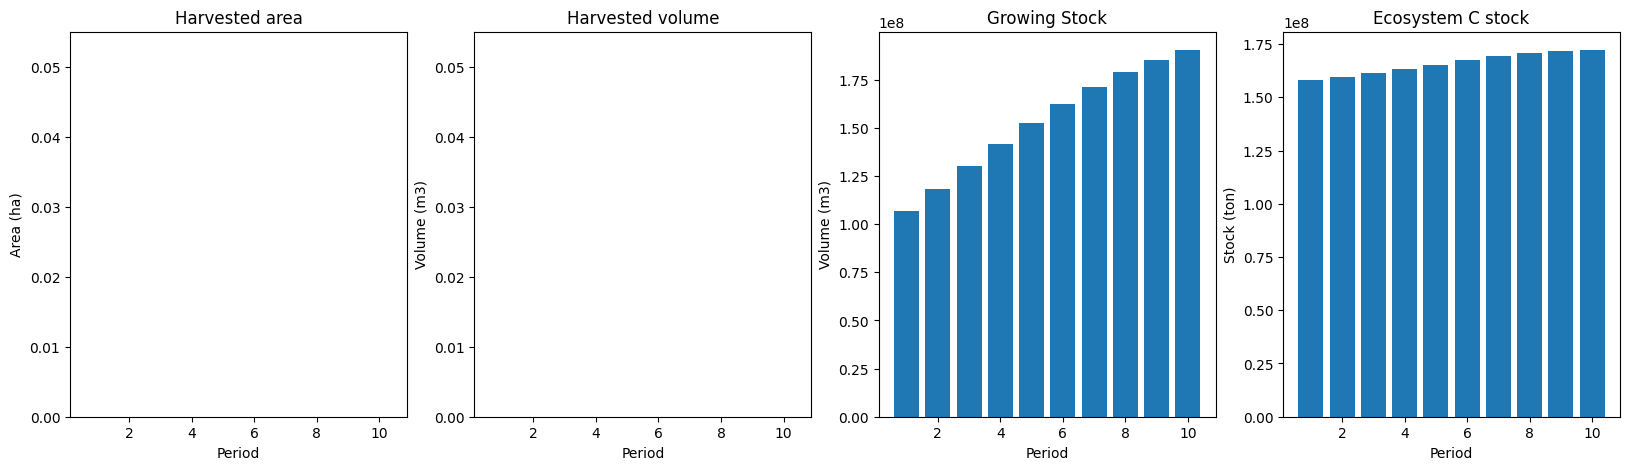

In [69]:
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

In [70]:
# softwood_volume_yname='swdvol' 
# hardwood_volume_yname='hwdvol'
# n_yield_vals=100

In [71]:
# sit_events = compile_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [72]:
# Replace the Sit_events file in the sit tables
# sit_tables['sit_events'] = sit_events

In [73]:
# sit_events

In [74]:

# sit_tables['sit_inventory']

In [75]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Stock_Change
Year,,,,,,
0,74.646219,85663.749470,85738.395689,0.000000,0.000000,0.000000
1,175.015069,84027.621068,84202.636138,1683.954457,148.194906,1535.759551
2,296.265311,82515.237323,82811.502634,1589.655202,198.521698,1391.133504
3,435.998209,81106.635565,81542.633773,1512.252270,243.383409,1268.868861
4,592.640501,79787.274550,80379.915051,1447.274615,284.555893,1162.718723
...,...,...,...,...,...,...
96,32296.363683,58631.092151,90927.455834,1380.031044,1784.404523,-404.373479
97,32625.385106,58707.809512,91333.194618,1385.218191,1790.956975,-405.738784
98,32952.385667,58786.599617,91738.985284,1390.358690,1796.149356,-405.790666


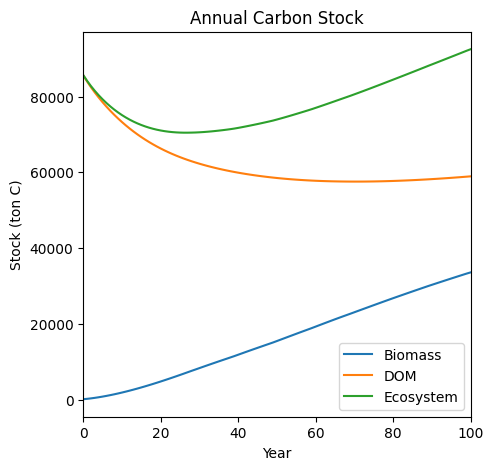

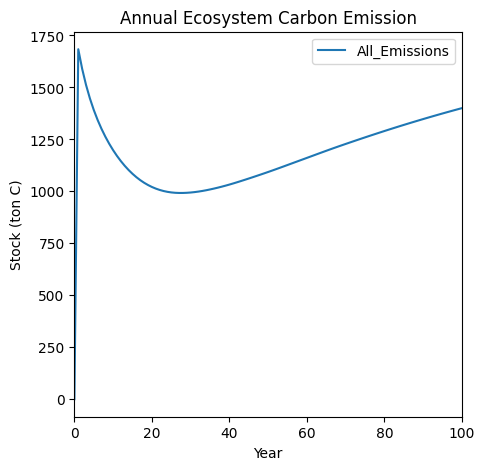

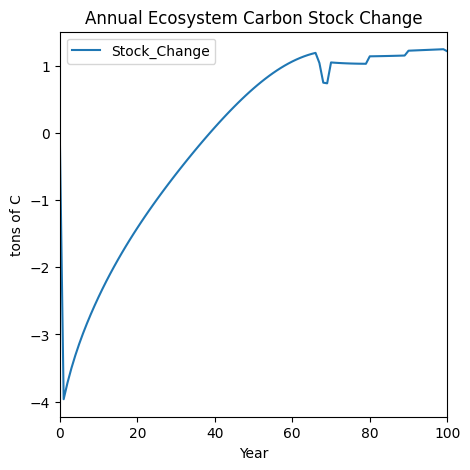

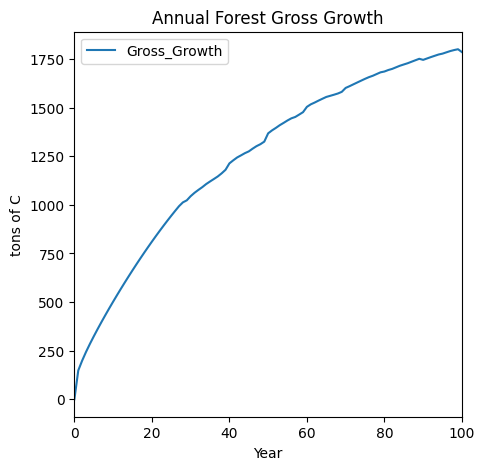

In [76]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

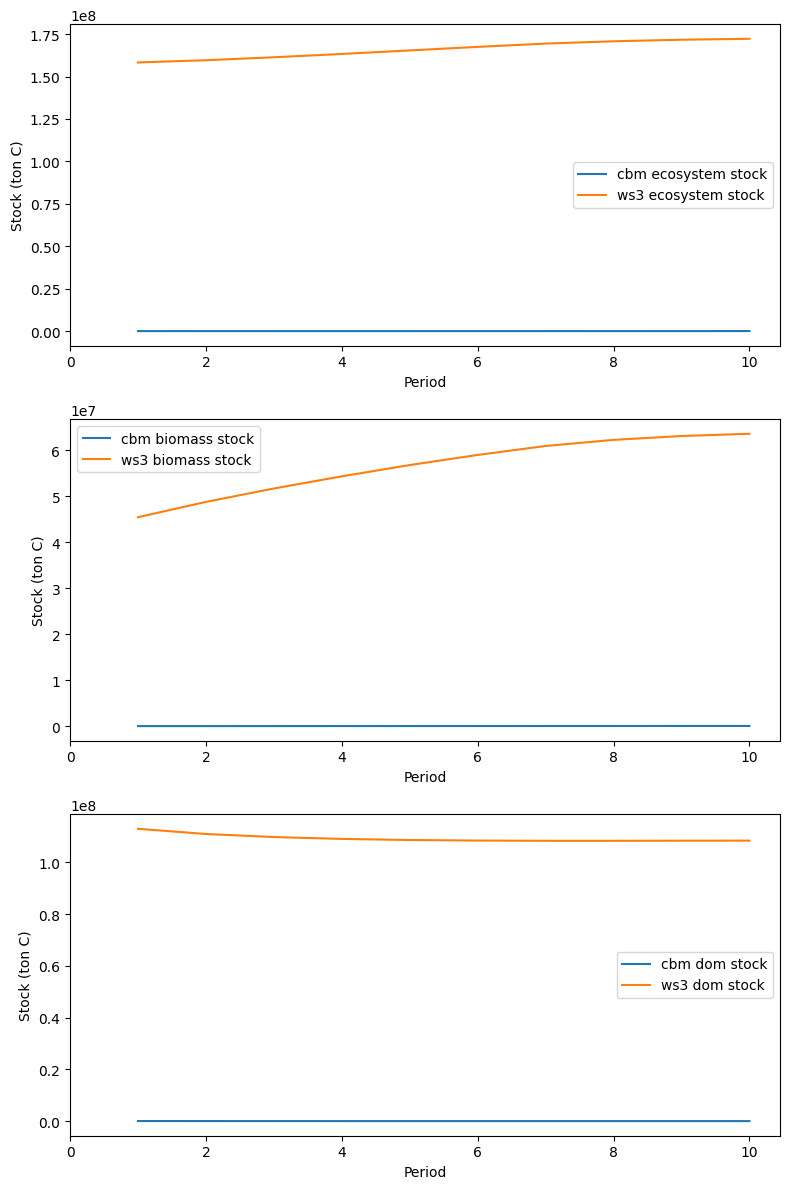

(   period  biomass_stock     dom_stock     eco_stock  eco_stock_change
 0       1     175.015069  84027.621068  84202.636138          0.000000
 1       2    2082.823604  72422.890271  74505.713876      -9696.922262
 2       3    5089.887289  65798.390493  70888.277782      -3617.436093
 3       4    8653.595628  61995.172383  70648.768011       -239.509771
 4       5   12195.121342  59742.947194  71938.068536       1289.300524
 5       6   15828.971006  58411.595536  74240.566542       2302.498007
 6       7   19648.223772  57739.684944  77387.908715       3147.342173
 7       8   23427.786014  57563.901235  80991.687249       3603.778533
 8       9   27125.293145  57767.262796  84892.555941       3900.868693
 9      10   30632.519563  58280.266962  88912.786525       4020.230584,
    period  biomass_stock     dom_stock     eco_stock  eco_stock_change
 0       1   4.542270e+07  1.129676e+08  1.582811e+08      0.000000e+00
 1       2   4.874701e+07  1.109550e+08  1.595903e+08      1.30

In [77]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
from util_opt import compare_ws3_cbm
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, plots="individual")

In [78]:
print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")

It took 18.4 minutes to run this script.
